In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv('Fraud.csv')


In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Looking into the "What Each Column" Reprsents....

- **`step`**  
  Represents a unit of time, where **1 step = 1 hour**. The dataset spans **744 steps** (i.e., 30 days).

- **`type`**  
  Type of transaction. It can be one of the following:  
  `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, or `TRANSFER`.

- **`amount`**  
  The value of the transaction, measured in local currency.

- **`nameOrig`**  
  The ID of the person or account that **initiated** the transaction.

- **`oldbalanceOrg`**  
  The sender's account balance **before** the transaction took place.

- **`newbalanceOrig`**  
  The sender's account balance **after** the transaction.

- **`nameDest`**  
  The ID of the person or account **receiving** the transaction.

- **`oldbalanceDest`**  
  The recipient’s account balance **before** the transaction.  
  *Note: For recipients whose IDs start with "M" (merchants), this value may be unavailable.*

- **`newbalanceDest`**  
  The recipient’s account balance **after** the transaction.  
  *Again, may be missing for merchants.*

- **`isFraud`**  
  Indicates whether the transaction is **fraudulent (`1`)** or **legitimate (`0`)**. Fraudulent activity often involves unauthorized transfers and cash-outs.

- **`isFlaggedFraud`**  
  Flags transactions that **violate fraud detection rules** — in this dataset, any `TRANSFER` over **200,000** units is flagged as suspicious.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


No Issues are present in Datatypes of columns.

In [7]:
# Checking for Null values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

No `Null Values` are present in the dataset

In [8]:
df['isFraud'].value_counts(normalize=True)


isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

In [9]:
df['isFraud'].value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

# Distribution of Transaction Type

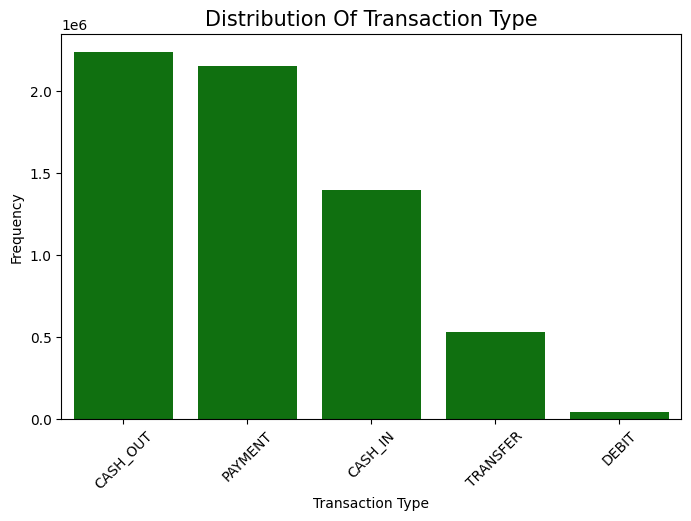

In [10]:
plt.figure(figsize=(8, 5)) 
sns.countplot(data=df, x='type', order=df['type'].value_counts().index,color='green')
plt.title('Distribution Of Transaction Type', fontsize=15)
plt.xlabel('Transaction Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Distribution of Transaction Amounts

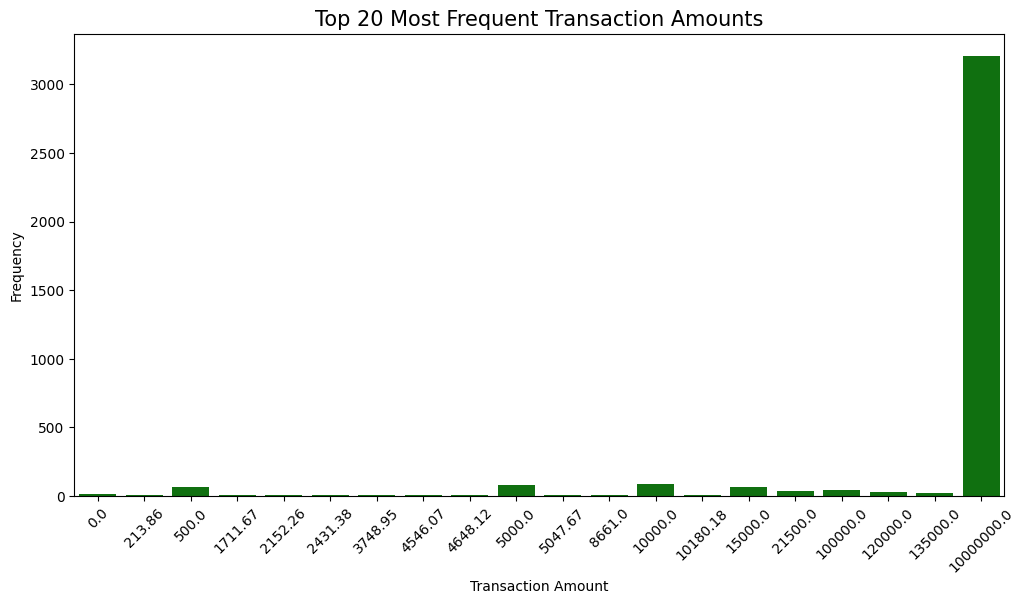

In [11]:
amount_counts = df['amount'].value_counts().sort_values(ascending=False).head(20).reset_index()
amount_counts.columns = ['amount', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(data=amount_counts, x='amount', y='count', color='green')
plt.title('Top 20 Most Frequent Transaction Amounts', fontsize=15)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# Which Transaction type is used more frequent?

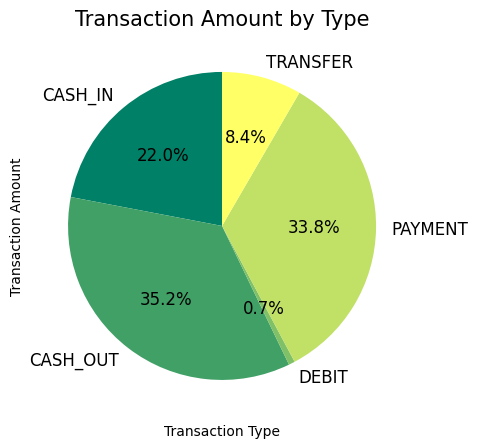

In [12]:
plt.figure(figsize=(8, 5))
df.groupby('type').count()['amount'].plot(kind='pie', color='blue', autopct='%1.1f%%', startangle=90,textprops={'fontsize': 12},colormap='summer')
plt.title('Transaction Amount by Type', fontsize=15)
plt.xlabel('Transaction Type')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45)
plt.show()

# Which type contributes more to fraud?

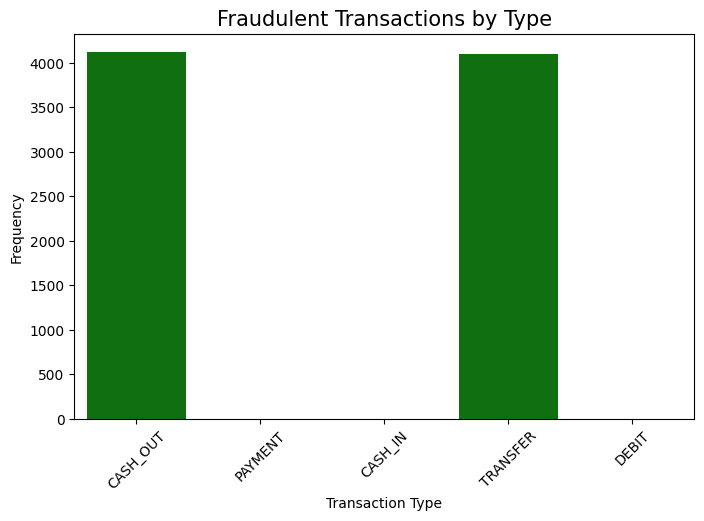

In [13]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df[df['isFraud'] == 1], x='type', order=df['type'].value_counts().index, color = 'green')
plt.title('Fraudulent Transactions by Type', fontsize=15)
plt.xlabel('Transaction Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### Observations that can be concluded based on the plots:

- There are 5 types of transactions namely - `CASH_OUT`,`PAYMENT`,`CASH_IN`,`TRANSFER`,`DEBIT`
- Among these transactions - `CASH_OUT` and `TRANSFER` mostly contribute to fraud.

If we look into What these types mean, We can probably determine how to approach model making.
- **CASH_OUT**: It means the amount that is being transferred or taken out.
- **PAYMENT**: Looks similar to CASH_OUT,but often used for bill payments or merchant transactions.
- **CASH_IN**: Probably means amount deposited or added.
- **TRANSFER**: Typically means transferring money between accounts.
- **DEBIT**: It could be from bank charges, service fees or maybe EMI's.

Both **`amount`** and **`isFraud`** are **highly skewed**:
- Most transaction amounts are small, with a few large outliers.
- Fraudulent cases make up a **very small portion** of the dataset.

This **imbalance and skewness** can affect model performance and should be handled carefully during preprocessing and training (we could go with class weighting, or Resampling Technique).

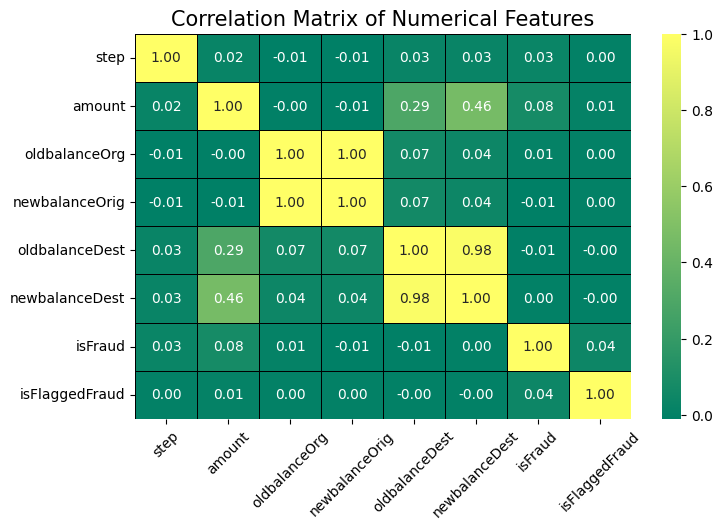

In [14]:
# Checking the correlation among numerical features
numerical_features = df.select_dtypes(include = 'number')
plt.figure(figsize=(8, 5))
sns.heatmap(numerical_features.corr(), annot=True, cmap='summer', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix of Numerical Features', fontsize=15)
plt.xticks(rotation=45)
plt.show()

### We can identify several crucial insights through the correlation heatmap

- High correlation is observed between `amount` and both `oldbalanceDest` and `newbalanceDest`.
- Moderate correlation is found between `amount` and `oldbalanceOrg`.
- There is weak correlation between `amount` and `isFraud`.

### Important Note

The raw balance features — `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, and `newbalanceDest` — may appear to be strong predictors of fraud. However, in many cases, especially for fraudulent transactions, these values are inconsistent or even misleading.

Using these raw features directly can lead to:

- **Data Leakage**: The model may learn specific fraudulent patterns that don't generalize to unseen data.
- **Overfitting**: The model might rely on balance anomalies that only exist in the training data due to synthetic or overly specific fraud cases.

---

### Safer Alternative: Feature Engineering

To retain useful signals while reducing overfitting and leakage, we created two derived features:

- `errorBalanceOrig = oldbalanceOrg - newbalanceOrig - amount`
- `errorBalanceDest = newbalanceDest - oldbalanceDest - amount`

These engineered features capture inconsistencies in balance changes during transactions and are more robust indicators of potential fraud.

---

### Therefore, we **excluded the original balance columns** and retained only the engineered `errorBalanceOrig` and `errorBalanceDest` in our model.

This approach helps the model:
- Focus on behavioral anomalies rather than memorizing balance values.
- Generalize better to unseen fraud patterns.
- Avoid artificial boosting of performance due to leakage.


### Model Building

In [15]:
# Selection of features for modeling
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

features = [
    'step', 'type', 'amount',
    'isFlaggedFraud', 'errorBalanceOrig', 'errorBalanceDest', 'isFraud'
]
df_model = df[features]

In [16]:
df_model.head()

,step,type,amount,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,isFraud
0,1,PAYMENT,9839.64,0,1.455192e-11,-9839.64,0
1,1,PAYMENT,1864.28,0,-1.136868e-12,-1864.28,0
2,1,TRANSFER,181.00,0,0.000000e+00,-181.00,1
3,1,CASH_OUT,181.00,0,0.000000e+00,-21363.00,1
4,1,PAYMENT,11668.14,0,0.000000e+00,-11668.14,0


In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_model.loc[:,'type'] = le.fit_transform(df_model.loc[:,'type'])

In [18]:
# Splitting into features and target variable
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

In [19]:
df_model.head()

,step,type,amount,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,isFraud
0,1,3,9839.64,0,1.455192e-11,-9839.64,0
1,1,3,1864.28,0,-1.136868e-12,-1864.28,0
2,1,4,181.00,0,0.000000e+00,-181.00,1
3,1,1,181.00,0,0.000000e+00,-21363.00,1
4,1,3,11668.14,0,0.000000e+00,-11668.14,0


In [20]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [21]:
print(X_scaled[:10])

[[-1.70304158e+00  9.52399323e-01 -2.81559923e-01 -1.58577857e-03
   3.31479982e-01  1.03566378e-01]
 [-1.70304158e+00  9.52399323e-01 -2.94767262e-01 -1.58577857e-03
   3.31479982e-01  1.21629438e-01]
 [-1.70304158e+00  1.69307616e+00 -2.97554804e-01 -1.58577857e-03
   3.31479982e-01  1.25441829e-01]
 [-1.70304158e+00 -5.28954357e-01 -2.97554804e-01 -1.58577857e-03
   3.31479982e-01  7.74676011e-02]
 [-1.70304158e+00  9.52399323e-01 -2.78531894e-01 -1.58577857e-03
   3.31479982e-01  9.94250849e-02]
 [-1.70304158e+00  9.52399323e-01 -2.84908275e-01 -1.58577857e-03
   3.31479982e-01  1.08145763e-01]
 [-1.70304158e+00  9.52399323e-01 -2.86083948e-01 -1.58577857e-03
   3.31479982e-01  1.09753677e-01]
 [-1.70304158e+00  9.52399323e-01 -2.84835526e-01 -1.58577857e-03
   3.31479982e-01  1.08046268e-01]
 [-1.70304158e+00  9.52399323e-01 -2.91190131e-01 -1.58577857e-03
   3.29249109e-01  1.16737163e-01]
 [-1.70304158e+00  2.11722483e-01 -2.89015100e-01 -1.58577857e-03
   3.31479982e-01  1.1025

### ***Splitting the data into training and testing set***

In [22]:
from sklearn.model_selection import train_test_split
X_scaled_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_scaled_train, y_train)

LogisticRegression()

In [24]:
y_pred = model.predict(X_test)

In [25]:
# Calculating the performance metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score, recall_score

accuracy_lr = accuracy_score(y_test, y_pred)
classific_report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)  
pre_score_lr = precision_score(y_test, y_pred)
recall_lr = recall_score(y_test, y_pred)


print("Confusion Matrix:\n", confusion)
print(f"Accuracy: {accuracy_lr}")
print("Classification Report:\n", classific_report)


Confusion Matrix:
 [[1270779     102]
 [    930     713]]
Accuracy: 0.9991890133309863
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.87      0.43      0.58      1643

    accuracy                           1.00   1272524
   macro avg       0.94      0.72      0.79   1272524
weighted avg       1.00      1.00      1.00   1272524



***Going Forward With Decision Tree (bcoz of Class Weights)***

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(class_weight='balanced',random_state=42)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [28]:
y_pred_dt = model_dt.predict(X_test)

In [29]:
# Calculating performance metrics for Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
classific_report_dt = classification_report(y_test, y_pred_dt)
confusion_dt = confusion_matrix(y_test, y_pred_dt)
pre_score_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)


print("Confusion Matrix (Decision Tree):\n", confusion_dt)
print(f"Accuracy (Decision Tree): {accuracy_dt}")
print("Classification Report (Decision Tree):\n", classific_report_dt)

Confusion Matrix (Decision Tree):
 [[1270619     262]
 [    344    1299]]
Accuracy (Decision Tree): 0.9995237810838931
Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.83      0.79      0.81      1643

    accuracy                           1.00   1272524
   macro avg       0.92      0.90      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524



### Moving With Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=20,
    criterion='gini',
    max_features='sqrt',
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42
)


In [31]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=20,
                       n_jobs=-1, random_state=42)

In [32]:
y_pred_rf = rf.predict(X_test)

In [33]:
# Claculating performance metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classific_report_rf = classification_report(y_test, y_pred_rf)
confusion_rf = confusion_matrix(y_test, y_pred_rf)
pre_score_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print("Confusion Matrix (Random Forest):\n", confusion_rf)
print(f"Accuracy (Random Forest): {accuracy_rf}")
print("Classification Report (Random Forest):\n", classific_report_rf)

Confusion Matrix (Random Forest):
 [[1270825      56]
 [    388    1255]]
Accuracy (Random Forest): 0.9996510871307732
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.96      0.76      0.85      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.88      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524



In [34]:
performance_df = pd.DataFrame({
    'models' : ['Logistic Regression', 'Decision Tree','Random Forest'],
    'accuracy' : [accuracy_lr, accuracy_dt, accuracy_rf],
    'precision' : [pre_score_lr, pre_score_dt, pre_score_rf],
    'recall' : [recall_lr, recall_dt, recall_rf]
})
performance_df

,models,accuracy,precision,recall
0,Logistic Regression,0.999189,0.874847,0.433962
1,Decision Tree,0.999524,0.832159,0.790627
2,Random Forest,0.999651,0.957285,0.763847


### We can `visualize the performance` of the models using a bar plot taking all the metrics into account

<Figure size 1000x600 with 0 Axes>

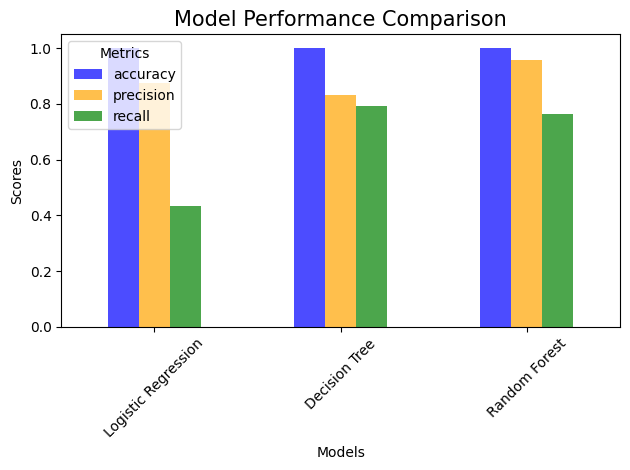

In [35]:
plt.figure(figsize=(10, 6))
performance_df.set_index('models').plot(kind='bar', rot=0, color=['blue', 'orange', 'green'], alpha=0.7)
plt.title('Model Performance Comparison', fontsize=15)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

### Model that is fit for this dataset can be concluded
- Though Decision Tree have better recall, Random Forest has better `precision` and `accuracy`.
- `Random Forest` is the `best model` for this dataset as it balances precision and recall effectively.
-  We do have more options to create a model , one such option is by using `SMOTE` to handle class imbalance or by using MLPClassifier.

### **Moving on the questions, that have been asked in the assignment**

### **`Ques 1:`** Data cleaning including missing values, outliers and multi-collinearity.
**`Ans:`**
The dataset didn't have any missing values, though there were some outliers, I didn't remove them as they are part of the dataset and can be useful for model training.
The multi-collinearity was checked with the help of correlation matrix and it was found that it is better to remove `'oldbalanceOrg'`, `'newbalanceOrig'`, `'oldbalanceDest'`, and `'newbalanceDest'` as they are highly correlated and could lead to overfitting or data leakage.
Two other features `'nameOrig'` and `'nameDest'` were also ** removed** as they are not useful for model training.

---

### **`Ques 2:`** Describe your fraud detection model in elaboration.
**`Ans:`** 
I tried building model using Logistic Regression, Decision Tree and Random Forest.
`Logistic Regression` is a linear model that is simple and interpretable, but **may not capture complex relationships** and it didn't show recall as good as Decision Tree and Random Forest..
In case of `Decision Tree`  which is a non-linear model it captured complex relationships, it also **showed better recall than Random Forest but lower precision**.
Where as in case of `Random Forest,`improved accuracy and reduced overfitting. It also showed the **best balance of precision and recall** among the three models.

Talking about randoem forest, I used `class_weight='balanced_subsample'` which handled `imbalance` in the dataset. This helped the model to give equal importance to both classes (fraud and non-fraud) during training.
I also set `max_features='sqrt'` to **reduce the number of features considered for splitting at each node**.
I also tried to reduce the model training time but failed to do so, as the dataset is large and it took a lot of time to train the model.
As the dataset don't have enough fraud cases, I tried to use **SMOTE** with Random Forest to handle class imbalance, but it didn't improve the performance of the model by much.

---

### **`Ques 3:`** How did you select variables to be included in the model?
**`Ans:`**
I selected the variable based on their correlation with the target variable that is `'isFraud'`. Also removed the columns that were not useful for model training like 'nameOrig' and `'nameDest'`.
If I were to talk about the reason why I removed `'oldbalanceOrg'`, `'newbalanceOrig'`, `'oldbalanceDest'`, and `'newbalanceDest'` was because they might have made the model overfit and could result in data leakage, since these values can be directly affected during fraudulent transactions.
And it could increase the chance of model finding patterns that are not generalizable to new data.

---

### **`Ques 4:`** Demonstrate the performance of the model by using best set of tools.
**`Ans:`**
The performance of the model was demonstrated using `accuracy`, `precision` and `recall` metrics, though accuracy was misleading in case of Logistic Regression, it was not the case with Decision Tree and Random Forest.
I've also added `confusion matrix` and `classification report` so as to show the performance of the model in detail for each algorithm.
Lastly, I **visualized the performance of the models using a bar plot** taking all the metrics into account.

---

### **`Ques 5 and 6:`** What are the key factors that predict fraudulent customer and Do these factors make sense? If yes, How? If not, How not??
**`Ans:`**
The key factors that predict fraudulent customer are the `transaction type`, `transaction amount`, and `the step of the transaction`.
The transaction type can be a key factor as some types of transactions are more prone to fraud than others.
The transaction amount can also be a key factor as larger transactions are more likely to be fraudulent.
The step of the transaction can also be a key factor as some times of the day are more prone to fraud than others.
The model can also be improved by using more features like 'oldBalanceOrg' and 'newBalanceOrg' which can help in predicting fraud cases better but it might introduce overfitting into the model.

---

### **`Ques 7:`** What kind of prevention should be adopted while company update its infrastructure?
**`Ans:`**
The company should have a well defined fraud detection policy in place, which could do regular audits of the transactions, monitor the transactions in real-time, and have a fraud detection team in place to investigate the fraud cases.
Additionally, the company can provide guidelines to the customers on how to avoid fraud and how to report fraud cases.
And the more fundamental thing to have a stable model is to keep updating it with latest fraud patterns.

---

### **`Ques 8:`** Assuming these actions have been implemented, how would you determine if they work?
**`Ans:`** 
Honestly Speaking, It's a challenge to determine if the actions have worked or not, as fraud cases can be very unpredictable and can change over time.
We can however reduce the number of fraud cases though not all of them can be prevented.
